<h3><center>Monte Carlo Simulation<br>
CUNY SPS MSDS<br>
Professor Samuel Gralnick<br>
Team Sugar Cane: Euclid Zhang, Jie Zou, Zhenni Xie<br>
Fall 2022</center></h3>

In this analysis, we calculate the prices of the European call options and European put options of the assets in our investment portfolio using Monte Carlo Simulations.

The Monte Carlo Simulation is a process of generating a large number of possible values of factors that impact the outcomes of an event. The distributions of the factors are defined, and the distribution of the outcomes is estimated with the simulated factor values. This process can be easily implemented with a few lines of codes or using existing packages.

The pandas-montecarlo package ( https://github.com/ranaroussi/pandas-montecarlo) is a lightweight Python library for running simple Monte Carlo Simulations on Pandas Series data. We may use the pandas-montecarlo package for our analysis. However, we found the following problems of the package after reviewing the codes of the library.

- The package performs **bootstrap simulation without replacement** from historical data instead of generating new independent samples from an estimated distribution. It may be fixed by performing **bootstrap simulation with replacement**. However, this will give us very limited number of discrete outcomes instead of countless outcomes from a continuous distribution.
- The package calculates the aggregated return by summing the daily percent changes. This is an unforgivable mistake. For example, if a stock is up by 10% on one and down by 10% on the next day, the total of change is 1.1 * 0.9 - 1 = -0.01. The calculation of the library gives 0%.
- Caused by the two problems above, the aggregated returns for all simulations have the same designation, which is the sum of all historical daily percent changes. It is apparently wrong to calculate option prices based on this only outcome.

Therefore, we will create our own coding for Monte Carlo simulation in this analysis. One thing to keep in mind when defining the distribution of the asset price for our simulation is that Monte Carlo simulation assumes perfectly efficient markets. The Efficient Market Hypothesis suggests a no arbitrage pricing model. The Black-Scholes Model is one of such models and it is commonly used for option pricing. The Black-Scholes Model assumes that the future log return of an asset followings the following distribution

$N(r-0.5\sigma^2, \sigma^2)$ where $r$ is the risk-free rate and $\sigma$ can be estimated using the standard deviation of the historical log returns. The return is $r$ if $\sigma$ is 0. It is impossible to get higher return without additional risk ($\sigma$). This is consistent with the Efficient Market Hypothesis. We will perform our simulation using this distribution. 



In [30]:
# Loading packages

import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import random

In [31]:
#The start date and end date of the assets' prices used for the calculations

start = datetime.strptime('2021-11-05', '%Y-%m-%d')
end = datetime.strptime('2022-11-05', '%Y-%m-%d')

#Seting up parameters for the option calculations. 

#1-year risk free rate from https://www.marketwatch.com/investing/bond/tmubmusd01y?countrycode=bx
risk_free_rate = 0.04791
#251 trade days in a year, used to annualized the return and standard deviation
n_trade_days = 251
#percentage of the current price, used as the strike price of the options
strike_price_pct = 1
#Expiration period of the option, 1 year
time_period = 1

Our investment portfolio includes the following assets, with purchasing prices (close prices) from 9/16/2022. In this analysis, we will not include the U.S. 30 Year Treasury bonds in our calculation

In [32]:
#Load the infromation of the assets in our portfolio

assets = pd.read_csv("portfolio assets.csv")
assets

,Ticker,Type,Sector,Price,Units,Amount
0,US30Y,U.S. 30 Year Treasury,NaN,90.44,467317.00,42262981.19
1,HSON,Common Stock,COMMERCIAL SERVICES,34.95,36138.24,1263031.49
2,GOGO,Common Stock,COMMUNICATIONS,13.32,94822.19,1263031.57
3,JAKK,Common Stock,CONSUMER DURABLES,23.37,54044.99,1263031.42
4,CALM,Common Stock,CONSUMER NON-DURABLES,56.85,22216.91,1263031.33
5,HRB,Common Stock,CONSUMER SERVICES,44.93,28111.09,1263031.27
6,HDSN,Common Stock,DISTRIBUTION SERVICES,7.94,159071.98,1263031.52
7,BELFA,Common Stock,ELECTRONIC TECHNOLOGY,28.52,44285.81,1263031.30
8,ARLP,Common Stock,ENERGY MINERALS,23.88,52890.76,1263031.35
9,CI,Common Stock,HEALTH SERVICES,290.35,4350.03,1263031.21


We then retrieve the prices and volumes of the common stocks and ETFs in our portfolio, using the yfinance package

In [33]:
#retrieve the prices and volumes of the common stocks and ETFs in our portfolio, using the yfinance package

yf.pdr_override()

tickers = list(assets['Ticker'])[1:]

historical_data = pdr.DataReader(tickers, start, end , data_source='yahoo')
historical_data = historical_data.reset_index()
historical_data.Date = historical_data.Date.apply(datetime.date)
historical_data.set_index('Date', inplace = True)

close_prices = historical_data['Adj Close']
close_prices

[*********************100%***********************]  29 of 29 completed


,ARLP,ASC,AZPN,BELFA,BSM,CALM,CF,CI,CSL,DIG,...,JAKK,LNG,MUSA,SRTS,TBT,TMV,TTT,TYO,UUP,YCS
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-05,10.832447,4.12,161.270004,15.338829,11.008157,35.715603,58.224865,210.304169,231.157074,21.064426,...,12.140000,107.028214,172.519104,4.13,16.959999,55.169998,31.150000,8.45,25.280001,40.345001
2021-11-08,10.730428,4.08,160.809998,15.932208,11.062474,36.122673,61.509846,214.272171,234.258713,21.478184,...,12.830000,107.236679,176.523300,4.10,16.980000,55.369999,31.280001,8.56,25.230000,40.270000
2021-11-09,10.461472,4.10,157.570007,15.408056,11.062474,35.550838,62.178646,212.347092,233.158768,21.609495,...,12.880000,106.134827,178.385956,4.67,16.559999,53.290001,30.049999,8.43,25.200001,40.005001
2021-11-10,10.007030,3.92,155.500000,15.210263,10.766735,35.327915,61.932762,213.957886,232.881302,20.462372,...,12.470000,103.821938,179.551346,4.83,17.160000,56.139999,31.719999,8.65,25.469999,40.715000
2021-11-11,10.109047,4.12,152.259995,14.834458,10.942330,35.124386,62.749096,213.820358,234.070435,20.675446,...,13.180000,103.454659,180.517532,4.76,17.209999,56.400002,31.980000,8.75,25.530001,40.830002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,23.769274,13.53,241.449997,29.280001,18.370001,56.509998,106.260002,323.059998,238.800003,46.049999,...,18.139999,176.410004,314.510010,14.07,35.980000,159.960007,90.970001,14.18,30.030001,68.889999
2022-11-01,24.327284,13.80,240.970001,32.540001,18.770000,57.259998,107.800003,325.119995,237.350006,46.880001,...,19.570000,179.860001,318.670013,14.28,35.200001,154.979996,88.040001,14.25,30.020000,68.389999
2022-11-02,23.544109,13.66,235.809998,31.879999,19.000000,57.259998,103.169998,320.859985,232.690002,44.849998,...,18.590000,178.619995,306.510010,13.35,35.419998,156.949997,88.930000,14.28,30.150000,68.080002


In the option price calculations, we use the log returns

In [34]:
#Calculate the daily log returns

log_return = np.log(close_prices / close_prices.shift(1)).dropna()

In order to perform the simulations, we calculate the $\sigma$ and $\mu=r-0.5\sigma^2$ for the distribution of the daily log returns.

In [35]:
sim_info = pd.DataFrame({"stock_price" : close_prices.iloc[len(close_prices)-1],
              "strike_price" : close_prices.iloc[len(close_prices)-1] * strike_price_pct,
              "risk_free_rate" : math.log(1+risk_free_rate),
              "time_period" : time_period,
              "daily_sigma" : log_return.std()})
sim_info['daily_mu'] = sim_info['risk_free_rate']/n_trade_days - 0.5*(sim_info['daily_sigma']**2)

In [36]:
sim_info.head(5)

,stock_price,strike_price,risk_free_rate,time_period,daily_sigma,daily_mu
ARLP,23.950001,23.950001,0.046798,1,0.029868,-0.000260
ASC,14.030000,14.030000,0.046798,1,0.037315,-0.000510
AZPN,233.009995,233.009995,0.046798,1,0.023182,-0.000082
BELFA,32.630001,32.630001,0.046798,1,0.030726,-0.000286
BSM,19.420000,19.420000,0.046798,1,0.021714,-0.000049


Define a function to simulate price movements based on the starting price, $\mu$ and $\sigma$ of the distribution of the daily log returns, and the number of periods (days) to be simulated.

In [37]:
def price_sim(start_price,mu, sigma, n_periods):
  return list(start_price *np.exp(np.cumsum(np.random.normal(mu, sigma, n_periods))))

Now, let's try to perform a simulation for 'ARLP' and see how the asset price is moving.

In [38]:
random.seed(618)

sim_result = []
n_sim = 10000
asset = 'ARLP'

for i in range(1,(n_sim+1)):
  sim_result.append(price_sim(sim_info.loc[asset,'stock_price'], 
                              sim_info.loc[asset,'daily_mu'], 
                              sim_info.loc[asset,'daily_sigma'], n_trade_days))

sim_result = pd.DataFrame(sim_result).T

Below shows 1000 simulated movements of the asset price. We can see that the prices are centered at the starting price and very unlikely to move up by a lot.

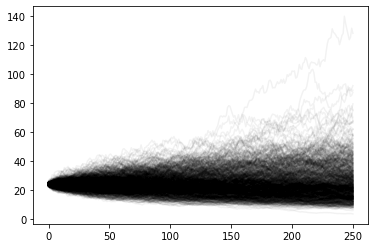

In [39]:
plt.plot(sim_result[pd.Series(sim_result.columns).sample(n=min(1000,n_sim))], color='black',alpha=0.05)
plt.show()

We can also check the distribution of the final prices. The distribution is log-normal which is consistent with the assumption of the Black-Scholes model.

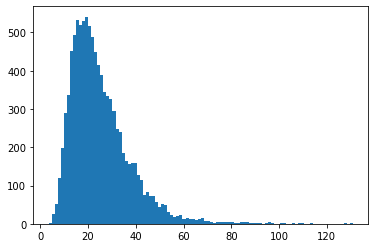

In [40]:
plt.hist(sim_result.iloc[len(sim_result)-1],bins=100)
plt.show()

We can then perform simulations for all assets and calculate the option prices based on the results of the simulation.

$P_{call}=  mean(max(final\_price - strike\_price,0)*e^{-r}) $  
$P_{put}=  mean(max(strike\_price - final\_price,0)*e^{-r}) $

In [41]:
random.seed(618)
sim_info['call_sim'] = 0
sim_info['put_sim'] = 0

for asset in sim_info.index:
  sim_result = []
  n_sim = 10000
  for i in range(1,(n_sim+1)):
    sim_result.append(price_sim(sim_info.loc[asset,'stock_price'], 
                                sim_info.loc[asset,'daily_mu'], 
                                sim_info.loc[asset,'daily_sigma'], n_trade_days))
  sim_result = pd.DataFrame(sim_result).T
  sim_info.loc[asset,'call_sim'] = np.mean([max(x-sim_info.loc[asset,'strike_price'],0)/
                                            np.exp(sim_info.loc[asset,'risk_free_rate']) 
                                            for x in sim_result.iloc[-1]])
  sim_info.loc[asset,'put_sim'] = np.mean([max(sim_info.loc[asset,'strike_price']-x,0)/
                                           np.exp(sim_info.loc[asset,'risk_free_rate']) 
                                           for x in sim_result.iloc[-1]])

In [42]:
sim_info.head(5)

,stock_price,strike_price,risk_free_rate,time_period,daily_sigma,daily_mu,call_sim,put_sim
ARLP,23.950001,23.950001,0.046798,1,0.029868,-0.000260,4.921912,3.914618
ASC,14.030000,14.030000,0.046798,1,0.037315,-0.000510,3.355578,2.925548
AZPN,233.009995,233.009995,0.046798,1,0.023182,-0.000082,39.220157,27.553737
BELFA,32.630001,32.630001,0.046798,1,0.030726,-0.000286,6.875883,5.410121
BSM,19.420000,19.420000,0.046798,1,0.021714,-0.000049,3.048242,2.143808


Now let's calculate the option prices using the Black Scholes formula and compare the results.

In [43]:
#Define a function to calculate the call option using the Black Scholes formula

def european_call(stock_price, strike_price, risk_free_rate, time_period, volatility):
  d_1 = (math.log(stock_price/strike_price) + (risk_free_rate + 0.5*(volatility**2))*time_period)/(volatility*math.sqrt(time_period))
  d_2 = d_1 - volatility*math.sqrt(time_period)
  option_price = stock_price * stats.norm.cdf(d_1) - strike_price * math.exp(-risk_free_rate*time_period) * stats.norm.cdf(d_2)
  return option_price

In [44]:
#Define a function to calculate the put option using the Black Scholes formula

def european_put(stock_price, strike_price, risk_free_rate, time_period, volatility):
  d_1 = (math.log(stock_price/strike_price) + (risk_free_rate + 0.5*(volatility**2))*time_period)/(volatility*math.sqrt(time_period))
  d_2 = d_1 - volatility*math.sqrt(time_period)
  option_price =  strike_price * math.exp(-risk_free_rate*time_period) * stats.norm.cdf(-d_2) - stock_price * stats.norm.cdf(-d_1)
  return option_price

In [45]:
#Gather the information for the option price calculation for each asset

asset_info = pd.DataFrame({"stock_price" : close_prices.iloc[len(close_prices)-1],
              "strike_price" : close_prices.iloc[len(close_prices)-1] * strike_price_pct,
              "risk_free_rate" : math.log(1+risk_free_rate),
              "time_period" : time_period,
              "volatility" : math.sqrt(n_trade_days) * log_return.std()})

In [46]:
#Calculate the prices of the call and put options

asset_info['call_BS'] = asset_info.apply(lambda x: european_call(x['stock_price'], 
                                         x['strike_price'],
                                         x['risk_free_rate'],
                                         x['time_period'],
                                         x['volatility']), axis=1)
asset_info['put_BS'] = asset_info.apply(lambda x: european_put(x['stock_price'], 
                                         x['strike_price'],
                                         x['risk_free_rate'],
                                         x['time_period'],
                                         x['volatility']), axis=1)

Combine the results to compare the option prices calculated using the Black-Scholes formula and the option prices calculated using Monte Carlo simulations

In [47]:
sim_bs_compare = asset_info.merge(sim_info[['call_sim','put_sim']], how = 'inner', left_index = True, right_index = True)
sim_bs_compare

,stock_price,strike_price,risk_free_rate,time_period,volatility,call_BS,put_BS,call_sim,put_sim
ARLP,23.950001,23.950001,0.046798,1,0.473192,4.945446,3.850463,4.921912,3.914618
ASC,14.030000,14.030000,0.046798,1,0.591182,3.517236,2.875790,3.355578,2.925548
AZPN,233.009995,233.009995,0.046798,1,0.367275,38.766395,28.113277,39.220157,27.553737
BELFA,32.630001,32.630001,0.046798,1,0.486784,6.904918,5.413088,6.875883,5.410121
BSM,19.420000,19.420000,0.046798,1,0.344013,3.059152,2.171278,3.048242,2.143808
CALM,57.480000,57.480000,0.046798,1,0.326349,8.668199,6.040237,8.876806,5.999748
CF,105.379997,105.379997,0.046798,1,0.497390,22.720428,17.902499,23.267359,17.716548
CI,322.130005,322.130005,0.046798,1,0.267453,41.357090,26.629443,41.076799,26.689906
CSL,225.570007,225.570007,0.046798,1,0.350068,36.052693,25.739729,35.761443,25.749973
DIG,47.529999,47.529999,0.046798,1,0.702704,13.870545,11.697493,13.887907,11.752958


The option prices calcualted using two different methods are very close. This proves that the Black-Scholes formula gives a fair price of the options. One advantage of Monte Carlo simulation over the Black-Scholes model is that Monte Carlo simulation can handle any kind of distributions of the returns while the B-S model is limited to the normal distribution. The Monte Carlo simulations can also provide a clear view of the price movements while most of the other methods focus only on the final results.